<p style="text-align: center;"><img alt="school-logo" src="../images/school_logo.png" style="zoom: 50%;" /></p>

<h1 align="center">本科生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">前馈神经网络实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">21281280</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">班级</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">物联网2101班</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">指导老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">张淳杰</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2023年10月24日</span></div>
</div>

实验环境：
- OS：Ubuntu 22.04 (Kernel: 6.2.0-34-generic)
- CPU：12th Gen Intel(R) Core(TM) i7-12700H
- GPU：NVIDIA GeForce RTX 3070 Ti Laptop
- cuda: 12.2
- conda: miniconda 23.9.0
- python：3.10.13
- pytorch：2.1.0

In [1]:
import time
import numpy as np
import torch
from torch.nn.functional import *
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

引用相关库。

# 任务一
**手动实现前馈神经网络解决上述回归、二分类、多分类任务。**
- 从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

首先生成数据集。

一共有3个数据集：

1. 回归任务数据集。
   - 生成单个数据集。
   - 数据集的大小为$10000$且训练集大小为$7000$，测试集大小为$3000$。
   - 数据集的样本特征维度$p$为$500$，且服从如下的高维线性函数：$y = 0.028 + \sum_{p}^{i=1}0.0056 x_i + \epsilon $。
2. 二分类任务数据集。
   - 共生成两个数据集。
   - 两个数据集的大小均为$10000$且训练集大小为$7000$，测试集大小为$3000$。
   - 两个数据集的样本特征$x$的维度均为$200$，且分别服从均值互为相反数且方差相同的正态分布。
   - 两个数据集的样本标签分别为$0$和$1$。
3. MNIST手写体数据集。
   - 该数据集包含$60,000$个用于训练的图像样本和$10,000$个用于测试的图像样本。
   - 图像是固定大小（$28\times 28$像素），其值为$0$到$1$。为每个图像都被平展并转换为$784$（$28 \times 28$）个特征的一维numpy数组。 

实现回归任务数据集。

In [2]:
class My_Regression_Dataset(Dataset):
    def __init__(self, train=True):
        data_size = 7000 if train else 3000
        np.random.seed(0)
        x = np.random.rand(data_size, 500) * 0.005
        noise = np.random.randn(data_size) * 1e-7
        y = 0.028 - 0.0056 * x.sum(axis=1) + noise
        y = y.reshape(-1, 1)
        self.data = [[x[i], y[i]] for i in range(x.shape[0])]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)
        return x, y

        
# 测试，并后面的训练创建变量
train_regression_dataset = My_Regression_Dataset(train=True)
test_regression_dataset = My_Regression_Dataset(train=False)

train_regression_dataset_size = len(train_regression_dataset)
test_regression_dataset_size = len(test_regression_dataset)
print(f"训练数据集大小：{train_regression_dataset_size}，测试数据集大小：{test_regression_dataset_size}")
x0, y0 = train_regression_dataset[0]
print(f"训练数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0][0] = {x0[0]}")
print(f"y[0] = {y0}")

训练数据集大小：7000，测试数据集大小：3000
训练数据集的第1对数据：
x[0]第1个特征维度数据x[0][0] = 0.002744067460298538
y[0] = tensor([0.0210])


实现二分类任务数据集。

In [3]:
class My_BinaryCLS_Dataset(Dataset):
    def __init__(self, train=True, num_features=200):
        num_samples = 7000 if train else 3000
        
        x_1 = np.random.normal(loc=-0.5, scale=0.2, size=(num_samples, num_features))
        x_2 = np.random.normal(loc=0.5, scale=0.2, size=(num_samples, num_features))
        
        labels_1 = np.zeros((num_samples, 1))
        labels_2 = np.ones((num_samples, 1))
        
        x = np.concatenate((x_1, x_2), axis=0)
        labels = np.concatenate((labels_1, labels_2), axis=0)
        self.data = [[x[i], labels[i]] for i in range(2 * num_samples)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
        x = torch.FloatTensor(x)
        y = torch.LongTensor(y)
        return x, y


# 测试，并后面的训练创建变量
train_binarycls_dataset = My_BinaryCLS_Dataset(train=True)
test_binarycls_dataset = My_BinaryCLS_Dataset(train=False)

train_binarycls_dataset_size = len(train_binarycls_dataset)
test_binarycls_dataset_size = len(test_binarycls_dataset)
print(f"训练数据集大小：{train_binarycls_dataset_size}，测试数据集大小：{test_binarycls_dataset_size}")
x0, y0 = train_binarycls_dataset[0]
print(f"训练数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0][0] = {x0[0]}")
print(f"y[0] = {y0}")

x7000, y7000 = train_binarycls_dataset[7000]
print(f"训练数据集的第7001对数据：")
print(f"x[7000]第1个特征维度数据x[7000][0] = {x7000[0]}")
print(f"y[7000] = {y7000}")

训练数据集大小：14000，测试数据集大小：6000
训练数据集的第1对数据：
x[0]第1个特征维度数据x[0][0] = -0.519691526889801
y[0] = tensor([0])
训练数据集的第7001对数据：
x[7000]第1个特征维度数据x[7000][0] = 0.3035626709461212
y[7000] = tensor([1])


使用MNIST数据集。

首先造一个展示图片的函数。

In [4]:
def imshow(img):
    img = img.squeeze().numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

调用`torchvision.datasets.MNIST()`，获取数据集。

训练数据集大小：60000，测试数据集大小：10000
训练数据集的第1对数据：
x[0]第1个特征维度数据x[0]的大小 = torch.Size([1, 28, 28])
y[0] = 5
x[0]的图像：


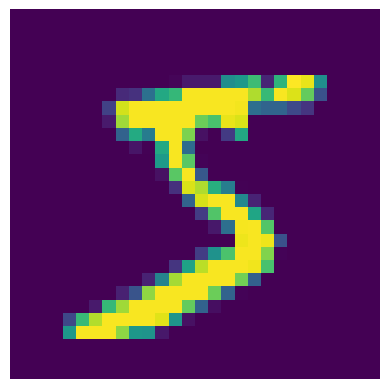

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_mnist_dataset = datasets.MNIST(root="dataset", train=True, transform=transform, download=True)
test_mnist_dataset = datasets.MNIST(root="dataset", train=False, transform=transform, download=True)

train_mnist_dataset_size = len(train_mnist_dataset)
test_mnist_dataset_size = len(test_mnist_dataset)
print(f"训练数据集大小：{train_mnist_dataset_size}，测试数据集大小：{test_mnist_dataset_size}")

x0, y0 = train_mnist_dataset[0]
print(f"训练数据集的第1对数据：")
print(f"x[0]第1个特征维度数据x[0]的大小 = {x0.shape}")
print(f"y[0] = {y0}")
print(f"x[0]的图像：")
imshow(x0)

接下来手动实现前馈神经网络并训练。

首先手动实现一些工具和基本模型层。这些工具都在前一个实验中实现并测试过，在此就不再分析其原理和具体实现步骤，也不在此重新测试。

In [6]:
# 手动实现torch.nn.functional.one_hot
def my_one_hot(indices: torch.Tensor, num_classes: int):
    one_hot_tensor = torch.zeros(len(indices), num_classes, dtype=torch.long).to(indices.device)
    one_hot_tensor.scatter_(1, indices.view(-1, 1), 1)
    return one_hot_tensor


# 手动实现torch.nn.functional.softmax
def my_softmax(predictions: torch.Tensor, dim: int):
    max_values = torch.max(predictions, dim=dim, keepdim=True).values
    exp_values = torch.exp(predictions - max_values)
    softmax_output = exp_values / torch.sum(exp_values, dim=dim, keepdim=True)
    return softmax_output


# 手动实现torch.nn.Linear
class My_Linear:
    def __init__(self, in_features: int, out_features: int):
        self.weight = torch.normal(mean=0.001, std=0.5, size=(out_features, in_features), requires_grad=True, dtype=torch.float32)
        self.bias = torch.normal(mean=0.001, std=0.5, size=(1,), requires_grad=True, dtype=torch.float32)
        self.params = [self.weight, self.bias]

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = torch.matmul(x, self.weight.T) + self.bias
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params

        
# 手动实现torch.nn.Flatten
class My_Flatten:
    def __call__(self, x: torch.Tensor):
        x = x.view(x.shape[0], -1)
        return x

        
# 手动实现torch.nn.ReLU
class My_ReLU():
    def __call__(self, x: torch.Tensor):
        x = torch.max(x, torch.tensor(0.0, device=x.device))
        return x


# 手动实现torch.nn.Sigmoid
class My_Sigmoid():
    def __call__(self, x: torch.Tensor):
        x = 1. / (1. + torch.exp(-x))
        return x


# 手动实现torch.nn.BCELoss
class My_BCELoss:
    def __call__(self, prediction: torch.Tensor, target: torch.Tensor):
        loss = -torch.mean(target * torch.log(prediction) + (1 - target) * torch.log(1 - prediction))
        return loss


# 手动实现torch.nn.CrossEntropyLoss
class My_CrossEntropyLoss:
    def __call__(self, predictions: torch.Tensor, targets: torch.Tensor):
        max_values = torch.max(predictions, dim=1, keepdim=True).values
        exp_values = torch.exp(predictions - max_values)
        softmax_output = exp_values / torch.sum(exp_values, dim=1, keepdim=True)

        log_probs = torch.log(softmax_output)
        nll_loss = -torch.sum(targets * log_probs, dim=1)
        average_loss = torch.mean(nll_loss)
        return average_loss


# 手动实现torch.optim.SGD
class My_optimizer:
    def __init__(self, params: list[torch.Tensor], lr: float):
        self.params = params
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param.data = param.data - self.lr * param.grad.data

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data = torch.zeros_like(param.grad.data)

首先造一个显示训练损失和测试正确率的函数。

In [7]:
def draw_loss_and_acc(train_loss:list[float], test_acc:list[float]):
    # train loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    
    # test acc
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

手动构建回归任务的模型。

In [8]:
class Model_1_1:
    def __init__(self):
        self.linear = My_Linear(in_features=500, out_features=1)
        self.sigmoid = My_Sigmoid()
        self.params = self.linear.params

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False

训练并测试上述回归模型。

Epoch [1/10], Train Loss: 2.8978282511234283, Used Time: 353.962ms, Test Acc: 36.794%, Used Time: 133.922ms
Epoch [2/10], Train Loss: 1.4448097050189972, Used Time: 175.900ms, Test Acc: 81.232%, Used Time: 128.733ms
Epoch [3/10], Train Loss: 1.4289481192827225, Used Time: 198.616ms, Test Acc: 93.077%, Used Time: 131.016ms
Epoch [4/10], Train Loss: 1.4270987510681152, Used Time: 197.384ms, Test Acc: 97.134%, Used Time: 135.690ms
Epoch [5/10], Train Loss: 1.4268036112189293, Used Time: 186.521ms, Test Acc: 98.251%, Used Time: 129.092ms
Epoch [6/10], Train Loss: 1.4267750978469849, Used Time: 186.903ms, Test Acc: 98.479%, Used Time: 129.014ms
Epoch [7/10], Train Loss: 1.4267622083425522, Used Time: 196.603ms, Test Acc: 98.527%, Used Time: 132.037ms
Epoch [8/10], Train Loss: 1.426765315234661, Used Time: 204.839ms, Test Acc: 98.537%, Used Time: 132.721ms
Epoch [9/10], Train Loss: 1.4267539158463478, Used Time: 194.532ms, Test Acc: 98.539%, Used Time: 132.098ms
Epoch [10/10], Train Loss: 1.

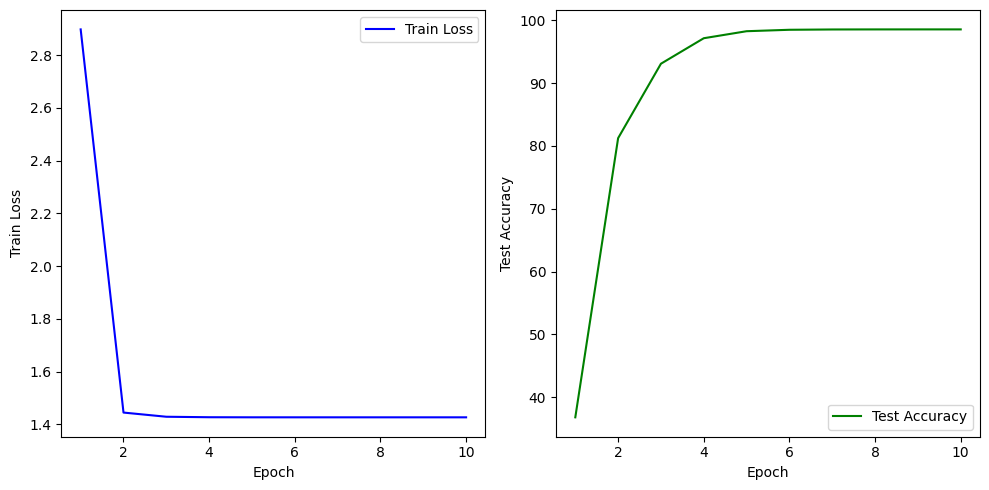

In [9]:
learning_rate = 3
num_epochs = 10
batch_size = 512
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(dataset=train_regression_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_dataloader = DataLoader(dataset=test_regression_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

model = Model_1_1().to(device)
criterion = My_BCELoss()
optimizer = My_optimizer(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (x, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        x = x.to(device)
        targets = targets.to(device)
        
        y_pred = model(x)
        
        loss = criterion(y_pred, targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (x, targets) in enumerate(test_dataloader):
            x = x.to(device)
            targets = targets.to(device)
            
            y_pred = model(x)
            total_epoch_acc += (1 - torch.abs(y_pred - targets) / torch.abs(targets)).sum().item()
            
        end_time = time.time()
        test_time = end_time - start_time
        
    avg_epoch_acc = total_epoch_acc / len(test_regression_dataset)
    print(
        f"Epoch [{epoch + 1}/{num_epochs}],",
        f"Train Loss: {total_epoch_loss},",
        f"Used Time: {train_time * 1000:.3f}ms,",
        f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
        f"Used Time: {test_time * 1000:.3f}ms",
    )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

手动构建二分类任务的模型。

In [10]:
class Model_1_2:
    def __init__(self):
        self.fc = My_Linear(in_features=200, out_features=1)
        self.sigmoid = My_Sigmoid()
        self.params = self.fc.parameters()

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False

训练并测试上述二分类模型。

Epoch [1/10], Train Loss: 57.00982600450516, Used Time: 230.368ms, Test Acc: 66.017%, Used Time: 166.204ms
Epoch [2/10], Train Loss: 10.472276136279106, Used Time: 209.454ms, Test Acc: 94.183%, Used Time: 175.770ms
Epoch [3/10], Train Loss: 4.121680565178394, Used Time: 213.171ms, Test Acc: 98.383%, Used Time: 172.317ms
Epoch [4/10], Train Loss: 2.3858484774827957, Used Time: 222.556ms, Test Acc: 99.400%, Used Time: 182.800ms
Epoch [5/10], Train Loss: 1.6423252075910568, Used Time: 183.790ms, Test Acc: 99.550%, Used Time: 190.588ms
Epoch [6/10], Train Loss: 1.232148002833128, Used Time: 224.288ms, Test Acc: 99.800%, Used Time: 212.908ms
Epoch [7/10], Train Loss: 0.9720441102981567, Used Time: 211.697ms, Test Acc: 99.900%, Used Time: 187.609ms
Epoch [8/10], Train Loss: 0.8034970238804817, Used Time: 219.023ms, Test Acc: 99.933%, Used Time: 163.564ms
Epoch [9/10], Train Loss: 0.6857249233871698, Used Time: 220.023ms, Test Acc: 99.933%, Used Time: 185.545ms
Epoch [10/10], Train Loss: 0.59

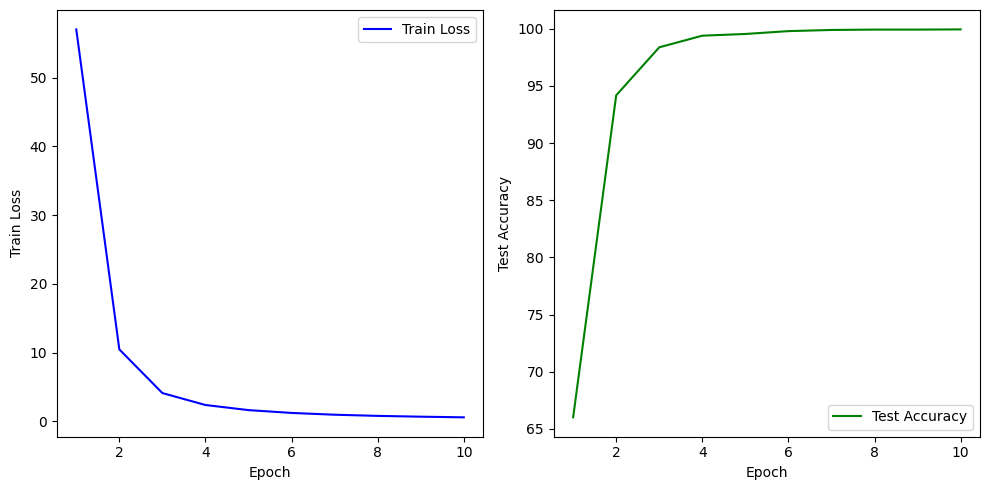

In [11]:
learning_rate = 5e-3
num_epochs = 10
batch_size = 512
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(dataset=train_binarycls_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_dataloader = DataLoader(dataset=test_binarycls_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

model = Model_1_2().to(device)
criterion = My_BCELoss()
optimizer = My_optimizer(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (x, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        x = x.to(device)
        targets = targets.to(device).to(dtype=torch.float)
        
        y_pred = model(x)
        loss = criterion(y_pred, targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (x, targets) in enumerate(test_dataloader):
            x = x.to(device)
            targets = targets.to(device)
            
            output = model(x)
            pred = (output > 0.5).to(dtype=torch.long)
            total_epoch_acc += (pred == targets).sum().item()
            
        end_time = time.time()
        test_time = end_time - start_time

    avg_epoch_acc = total_epoch_acc / len(test_binarycls_dataset)
    print(
        f"Epoch [{epoch + 1}/{num_epochs}],",
        f"Train Loss: {total_epoch_loss},",
        f"Used Time: {train_time * 1000:.3f}ms,",
        f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
        f"Used Time: {test_time * 1000:.3f}ms",
    )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

手动构建MNIST多分类任务的模型。

In [12]:
class Model_1_3:
    def __init__(self, num_classes):
        self.flatten = My_Flatten()
        self.linear = My_Linear(in_features=28 * 28, out_features=num_classes)
        self.params = self.linear.params

    def __call__(self, x: torch.Tensor):
        return self.forward(x)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params
    
    def train(self):
        for param in self.params:
            param.requires_grad = True
    
    def eval(self):
        for param in self.params:
            param.requires_grad = False

训练并测试上述MNIST多分类模型。

Epoch [1/10], Train Loss: 367.9293797016144, Used Time: 751.721ms, Test Acc: 73.320%, Used Time: 294.007ms
Epoch [2/10], Train Loss: 133.2528795003891, Used Time: 769.317ms, Test Acc: 79.920%, Used Time: 266.492ms
Epoch [3/10], Train Loss: 106.34030884504318, Used Time: 765.257ms, Test Acc: 80.740%, Used Time: 285.056ms
Epoch [4/10], Train Loss: 93.35072726011276, Used Time: 778.732ms, Test Acc: 84.460%, Used Time: 256.720ms
Epoch [5/10], Train Loss: 85.63974636793137, Used Time: 754.908ms, Test Acc: 83.050%, Used Time: 273.081ms
Epoch [6/10], Train Loss: 79.69779297709465, Used Time: 756.135ms, Test Acc: 85.490%, Used Time: 248.706ms
Epoch [7/10], Train Loss: 75.14733672142029, Used Time: 808.793ms, Test Acc: 86.180%, Used Time: 269.727ms
Epoch [8/10], Train Loss: 71.68338397145271, Used Time: 755.723ms, Test Acc: 86.310%, Used Time: 284.321ms
Epoch [9/10], Train Loss: 68.71114844083786, Used Time: 747.782ms, Test Acc: 86.920%, Used Time: 278.054ms
Epoch [10/10], Train Loss: 66.337508

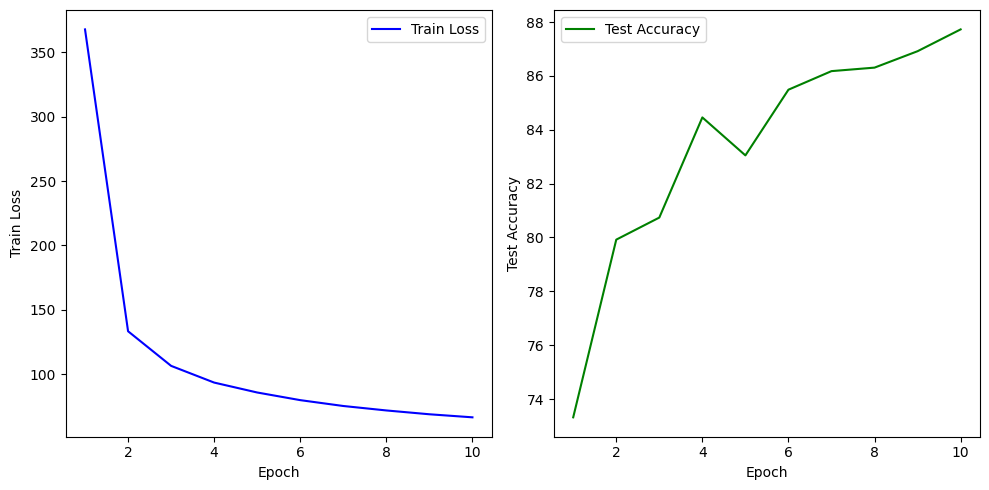

In [13]:
learning_rate = 1e-1
num_epochs = 10
batch_size = 512
num_classes = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_loader = DataLoader(dataset=train_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_loader = DataLoader(dataset=test_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

model = Model_1_3(num_classes).to(device)
criterion = My_CrossEntropyLoss()
optimizer = My_optimizer(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)
        one_hot_targets = my_one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

        outputs = model(images)
        loss = criterion(outputs, one_hot_targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (image, targets) in enumerate(test_loader):
            image = image.to(device)
            targets = targets.to(device)
            
            outputs = model(image)
            pred = my_softmax(outputs, dim=1)
            total_epoch_acc += (pred.argmax(1) == targets).sum().item()
        
        end_time = time.time()
        test_time = end_time - start_time
    
    avg_epoch_acc = total_epoch_acc / len(test_mnist_dataset)
    print(
        f"Epoch [{epoch + 1}/{num_epochs}],",
        f"Train Loss: {total_epoch_loss},",
        f"Used Time: {train_time * 1000:.3f}ms,",
        f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
        f"Used Time: {test_time * 1000:.3f}ms",
    )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

# 任务二
**利用torch.nn实现前馈神经网络解决上述回归、二分类、多分类任务。**
- 从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

使用`torch.nn`构建回归任务的模型。

In [14]:
class Model_2_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=500, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

训练并测试上述二分类模型。

Epoch [1/10], Train Loss: 2.1101853772997856, Used Time: 195.015ms, Test Acc: 78.956%, Used Time: 144.186ms
Epoch [2/10], Train Loss: 1.4286116436123848, Used Time: 214.837ms, Test Acc: 96.060%, Used Time: 146.329ms
Epoch [3/10], Train Loss: 1.4267941787838936, Used Time: 214.863ms, Test Acc: 99.014%, Used Time: 147.720ms
Epoch [4/10], Train Loss: 1.4267428517341614, Used Time: 195.811ms, Test Acc: 99.311%, Used Time: 150.746ms
Epoch [5/10], Train Loss: 1.426711082458496, Used Time: 212.999ms, Test Acc: 99.330%, Used Time: 144.737ms
Epoch [6/10], Train Loss: 1.4266885295510292, Used Time: 220.414ms, Test Acc: 99.332%, Used Time: 153.153ms
Epoch [7/10], Train Loss: 1.4267256334424019, Used Time: 219.407ms, Test Acc: 99.332%, Used Time: 148.779ms
Epoch [8/10], Train Loss: 1.426725186407566, Used Time: 184.097ms, Test Acc: 99.332%, Used Time: 150.357ms
Epoch [9/10], Train Loss: 1.4267201945185661, Used Time: 213.742ms, Test Acc: 99.332%, Used Time: 148.762ms
Epoch [10/10], Train Loss: 1.4

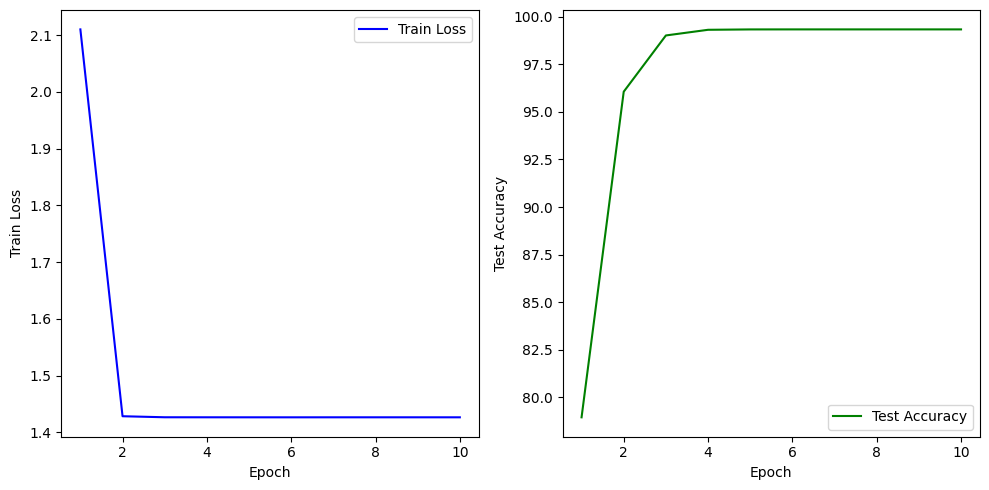

In [15]:
learning_rate = 5
num_epochs = 10
batch_size = 512
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(dataset=train_regression_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_dataloader = DataLoader(dataset=test_regression_dataset, batch_size=batch_size, shuffle=True, num_workers=14,  pin_memory=True)

model = Model_2_1().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (x, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        x = x.to(device)
        targets = targets.to(device)
        
        y_pred = model(x)
        
        loss = criterion(y_pred, targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (x, targets) in enumerate(test_dataloader):
            x = x.to(device)
            targets = targets.to(device)
            
            y_pred = model(x)
            total_epoch_acc += (1 - torch.abs(y_pred - targets) / torch.abs(targets)).sum().item()
            
        end_time = time.time()
        test_time = end_time - start_time
        
    avg_epoch_acc = total_epoch_acc / len(test_regression_dataset)
    print(
        f"Epoch [{epoch + 1}/{num_epochs}],",
        f"Train Loss: {total_epoch_loss},",
        f"Used Time: {train_time * 1000:.3f}ms,",
        f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
        f"Used Time: {test_time * 1000:.3f}ms",
    )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

使用`torch.nn`构建二分类任务的模型。

In [16]:
class Model_2_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(in_features=200, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

训练并测试上述二分类模型。

Epoch [1/10], Train Loss: 21.56280481815338, Used Time: 248.327ms, Test Acc: 18.617%, Used Time: 191.476ms
Epoch [2/10], Train Loss: 20.48189949989319, Used Time: 225.974ms, Test Acc: 39.233%, Used Time: 197.265ms
Epoch [3/10], Train Loss: 19.458877623081207, Used Time: 229.453ms, Test Acc: 62.983%, Used Time: 182.790ms
Epoch [4/10], Train Loss: 18.516239285469055, Used Time: 229.176ms, Test Acc: 81.850%, Used Time: 199.854ms
Epoch [5/10], Train Loss: 17.630264461040497, Used Time: 221.416ms, Test Acc: 93.067%, Used Time: 205.765ms
Epoch [6/10], Train Loss: 16.80879431962967, Used Time: 230.655ms, Test Acc: 97.967%, Used Time: 193.758ms
Epoch [7/10], Train Loss: 16.03673541545868, Used Time: 241.642ms, Test Acc: 99.467%, Used Time: 192.214ms
Epoch [8/10], Train Loss: 15.317354381084442, Used Time: 202.092ms, Test Acc: 99.800%, Used Time: 187.985ms
Epoch [9/10], Train Loss: 14.644242405891418, Used Time: 222.552ms, Test Acc: 100.000%, Used Time: 205.953ms
Epoch [10/10], Train Loss: 14.0

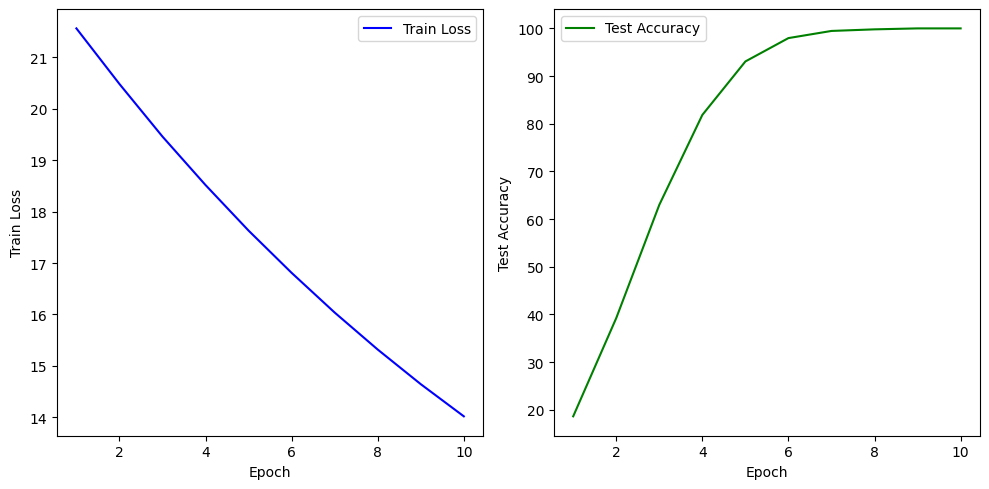

In [17]:
learning_rate = 1e-4
num_epochs = 10
batch_size = 512
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(dataset=train_binarycls_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
test_dataloader = DataLoader(dataset=test_binarycls_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

model = Model_2_2().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (x, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()

        x = x.to(device)
        targets = targets.to(device).to(dtype=torch.float32)
        
        y_pred = model(x)
        loss = criterion(y_pred, targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (x, targets) in enumerate(test_dataloader):
            x = x.to(device)
            targets = targets.to(device)
            
            output = model(x)
            pred = (output > 0.5).to(dtype=torch.long)
            total_epoch_acc += (pred == targets).sum().item()
            
        end_time = time.time()
        test_time = end_time - start_time

    avg_epoch_acc = total_epoch_acc / len(test_binarycls_dataset)
    print(
        f"Epoch [{epoch + 1}/{num_epochs}],",
        f"Train Loss: {total_epoch_loss},",
        f"Used Time: {train_time * 1000:.3f}ms,",
        f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
        f"Used Time: {test_time * 1000:.3f}ms",
    )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)

使用`torch.nn`构建MNIST多分类任务的模型。

In [18]:
class Model_2_3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=28 * 28, out_features=num_classes)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear(x)
        return x

训练并测试上述MNIST多分类模型。

Epoch [1/10], Train Loss: 90.53274163603783, Used Time: 781.786ms, Test Acc: 87.310%, Used Time: 266.083ms
Epoch [2/10], Train Loss: 50.167335361242294, Used Time: 752.594ms, Test Acc: 88.780%, Used Time: 296.608ms
Epoch [3/10], Train Loss: 44.92860543727875, Used Time: 795.665ms, Test Acc: 90.020%, Used Time: 272.585ms
Epoch [4/10], Train Loss: 42.10635221004486, Used Time: 777.619ms, Test Acc: 90.360%, Used Time: 280.241ms
Epoch [5/10], Train Loss: 40.80511271953583, Used Time: 753.084ms, Test Acc: 90.780%, Used Time: 264.655ms
Epoch [6/10], Train Loss: 39.463319301605225, Used Time: 774.873ms, Test Acc: 90.720%, Used Time: 273.553ms
Epoch [7/10], Train Loss: 38.5654878616333, Used Time: 757.741ms, Test Acc: 91.230%, Used Time: 261.461ms
Epoch [8/10], Train Loss: 38.006617456674576, Used Time: 746.465ms, Test Acc: 89.940%, Used Time: 276.766ms
Epoch [9/10], Train Loss: 37.3043093085289, Used Time: 759.912ms, Test Acc: 90.930%, Used Time: 288.009ms
Epoch [10/10], Train Loss: 36.952361

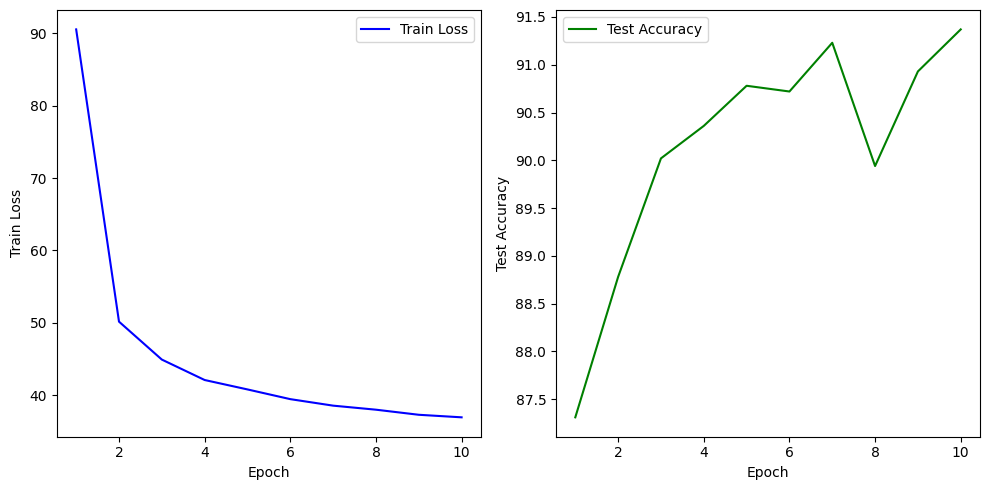

In [22]:
learning_rate = 5e-2
num_epochs = 10
batch_size = 512
num_classes = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_loader = DataLoader(dataset=train_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True,)
test_loader = DataLoader(dataset=test_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14,pin_memory=True)

model = Model_2_3(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss = list()
test_acc = list()
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    start_time = time.time()
    for index, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)
        one_hot_targets = one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

        outputs = model(images)
        loss = criterion(outputs, one_hot_targets)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()
    train_time = end_time - start_time

    model.eval()
    with torch.no_grad():
        total_epoch_acc = 0
        start_time = time.time()
        for index, (image, targets) in enumerate(test_loader):
            image = image.to(device)
            targets = targets.to(device)
            
            outputs = model(image)
            pred = softmax(outputs, dim=1)
            total_epoch_acc += (pred.argmax(1) == targets).sum().item()
        
        end_time = time.time()
        test_time = end_time - start_time
    
    avg_epoch_acc = total_epoch_acc / len(test_mnist_dataset)
    print(
        f"Epoch [{epoch + 1}/{num_epochs}],",
        f"Train Loss: {total_epoch_loss},",
        f"Used Time: {train_time * 1000:.3f}ms,",
        f"Test Acc: {avg_epoch_acc * 100:.3f}%,",
        f"Used Time: {test_time * 1000:.3f}ms",
    )
    train_loss.append(total_epoch_loss)
    test_acc.append(avg_epoch_acc * 100)
    
draw_loss_and_acc(train_loss, test_acc)